Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
    
  #trim validation dataset (maybe we use it for cross validation later)
  valid_dataset = valid_dataset[:18724,:,:]
  valid_labels = valid_labels[:18724]
    
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (300000, 28, 28), (300000,))
('Validation set', (18724, 28, 28), (18724,))
('Test set', (18724, 28, 28), (18724,))


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (300000, 28, 28, 1), (300000, 10))
('Validation set', (18724, 28, 28, 1), (18724, 10))
('Test set', (18724, 28, 28, 1), (18724, 10))


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size / 4 * image_size / 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [10]:
import math

def weight_variable(shape, prev_n_count=2, name=None):
    initial = tf.truncated_normal(shape, stddev=math.sqrt(2.0/prev_n_count))
    #initial = tf.truncated_normal(shape)
    return tf.Variable(initial, name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial, name)

def train_model(num_steps, checkpoint_every, batch_size, graph, is_saving=False, keep_prob = 0.5, restore=False):
    with tf.Session(graph=graph) as session:
        if restore:
            ckpt = tf.train.get_checkpoint_state('./')
            #print ckpt
            if ckpt and ckpt.model_checkpoint_path:                
                filename = ckpt.model_checkpoint_path
            saver.restore(session, filename)
            print 'session restored from %s' % filename
        else:
            tf.initialize_all_variables().run()
            print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                         tf_batch_size: batch_size, tf_keep_prob: keep_prob}
            _, l, lr = session.run([optimizer, loss, learning_rate], feed_dict=feed_dict)
            if (step % checkpoint_every == 0):
                print("Minibatch loss at step %d: %f with learning rate %f" % (step, l, lr))
                train_accuracy = accuracy_l.eval(feed_dict={tf_train_dataset:batch_data, tf_train_labels: batch_labels,
                                                           tf_keep_prob: 1.0})
                print "step %d, training accuracy %g" % (step, train_accuracy)                
                print("Validation accuracy: %g" %
                    accuracy_l.eval(feed_dict={ tf_train_dataset: valid_dataset, tf_train_labels: valid_labels,
                                              tf_keep_prob: 1.0}))
                #save model
                if(is_saving):
                    saver.save(session, './model.ckpt', global_step=step)
        print("test accuracy %g" % 
              accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset,
                                                              tf_train_labels: test_labels, tf_keep_prob: 1.0}))
        
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import random

def predict_letter(image, session):
    with session.as_default():
        probs = y_conv.eval(feed_dict={ tf_train_dataset: [image], tf_train_labels: [[0,0,0,0,0,0,0,0,0,0]],
                                      tf_keep_prob: 1.0})
    #print probs
    return tf.argmax(probs,1).eval() #return index of max value

def find_incorrect(dataset, labels, session):
    with session.as_default():
        #tensor with True when prediction == label
        correct_predicitons = is_correct_prediction.eval(feed_dict={ tf_train_dataset: dataset,
                                                                    tf_train_labels: labels, tf_keep_prob: 1.0})
    #return indexes of invalid
    return np.where(correct_predicitons == False)
    

def display_sample(dataset, labels, title_label, session=None):    
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()    
    fig.suptitle(title_label, color='white')
    fig.patch.set_facecolor('black')
    for d in range(0, 16):
        a=fig.add_subplot(gs[d])
        letter_idx = int(len(dataset)*random.random())
        #print(letter_idx)
        plt.imshow(dataset[letter_idx].reshape((28,28)), cmap = cm.Greys_r)
        l_title = chr(tf.argmax(labels[letter_idx],0).eval() + ord('A'))
        if session is not None:
            letter_class = predict_letter(dataset[letter_idx], session)
            #print letter_class
            l_title = l_title + ' / ~' + chr(letter_class + ord('A'))
        a.set_title(l_title, color='white')
        a.axis('off')    
    plt.show()
    
def display_incorrect_sample(dataset, labels, title_label, num, session=None):    
    gs = gridspec.GridSpec(4, int(num / 4) + (0 if num % 4 == 0 else 1))
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()
    fig.suptitle(title_label, color='white')
    fig.patch.set_facecolor('black')
    incorrect = find_incorrect(dataset, labels, session)[0]
    no_incorrect = len(incorrect)
    print('Incorrect no: %i' % no_incorrect)
    #get permutation of incorrects
    incorrect = incorrect[np.random.permutation(no_incorrect)]
    for d in range(0, num):
        a=fig.add_subplot(gs[d])             
        letter_idx = incorrect[d]
        #print(letter_idx)
        plt.imshow(dataset[letter_idx].reshape((28,28)), cmap = cm.Greys_r)
        l_title = chr(tf.argmax(labels[letter_idx],0).eval() + ord('A'))
        if session is not None:
            letter_class = predict_letter(dataset[letter_idx], session)
            #print letter_class
            l_title = l_title + ' / ~' + chr(letter_class + ord('A'))
        a.set_title(l_title, color='white')
        a.axis('off')    
    plt.show()
    
def restore_and_display_test(graph, title, display_all=False):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.initialize_all_variables())
        #load model
        if display_all:
            filenames = saver.last_checkpoints
        else:
            ckpt = tf.train.get_checkpoint_state('./')
            #print ckpt
            if ckpt and ckpt.model_checkpoint_path:                
                filenames = [ckpt.model_checkpoint_path]
        for fn in filenames:
            saver.restore(sess, fn)
            print("test accuracy %g %s" %
                (accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels,
                                        tf_keep_prob: 1.0}), fn))
            #display_sample(test_dataset, test_labels, title +' %s' % fn, num_samples, sess)
        
def restore_and_display_random_incorrect(num_samples, graph, title, display_all=False):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.initialize_all_variables())
        #load model
        if display_all:
            filenames = tf.train.last_checkpoints
        else:
            ckpt = tf.train.get_checkpoint_state('./')
            #print ckpt
            if ckpt and ckpt.model_checkpoint_path:                
                filenames = [ckpt.model_checkpoint_path]
        for fn in filenames:
            saver.restore(sess, fn)
            print("test accuracy %g" % 
                accuracy_l.eval(feed_dict={ tf_train_dataset: test_dataset, tf_train_labels: test_labels,
                                        tf_keep_prob: 1.0}))
            display_incorrect_sample(test_dataset, test_labels, title +' %s' % fn, num_samples, sess)

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [25]:
patch_size = 5
depth = 16
hidden_nodes = 64

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_batch_size = tf.placeholder(tf.int32)
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))    
    tf_keep_prob = tf.placeholder(tf.float32)

    # Variables.
    # input layer variables
    weights_conv1 = weight_variable([patch_size, patch_size, num_channels, depth], patch_size * patch_size)
    biases_conv1 = bias_variable([depth])
    weights_conv2 = weight_variable([patch_size, patch_size, depth, depth], patch_size * patch_size)
    biases_conv2 = bias_variable([depth])
    weights_h1 = weight_variable([image_size / 4 * image_size / 4 * depth, hidden_nodes],
                                 image_size / 4 * image_size / 4 * depth)
    biases_h1 = bias_variable([hidden_nodes])        
    # output layer variables
    weights_o = weight_variable([hidden_nodes, num_labels], hidden_nodes)
    biases_o = bias_variable([num_labels])        
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights_conv1, strides=[1, 1, 1, 1], padding='SAME')        
        #conv = tf.nn.conv2d(data, weights_conv1, strides=[1, 2, 2, 1], padding='SAME')        
        pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(pool + biases_conv1)
        
        
        conv = tf.nn.conv2d(hidden, weights_conv2, strides=[1, 1, 1, 1], padding='SAME')        
        #conv = tf.nn.conv2d(hidden, weights_conv2, strides=[1, 2, 2, 1], padding='SAME')        
        pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(pool + biases_conv2)
        
        #reshape multidimensional output to flat to connect to dense hidden layer
        #shape = pool.get_shape().as_list()
        #hidden_flat = tf.reshape(pool, [-1, shape[1] * shape[2] * shape[3]])
        shape = hidden.get_shape().as_list()
        hidden_flat = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(hidden_flat, weights_h1) + biases_h1)
        return tf.matmul(hidden, weights_o) + biases_o

    #output operation
    logits_o = model(tf_train_dataset)    
    y_conv = tf.nn.softmax(logits_o) #after softmax -> output probabilities / predictions
    #define loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels))
                        #+ (2.0/(3*hidden_nodes))*(tf.nn.l2_loss(weights_i)
                        #+ tf.nn.l2_loss(weights_h2)
                        #+ tf.nn.l2_loss(weights_h3)))
    #decay learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step * tf_batch_size, train_dataset.shape[0] / 1, 0.95, staircase=True)
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #learning_rate = tf.constant(0.01)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #define operations to measure accuracy
    is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
    accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    #train_prediction = tf.nn.softmax(logits_o)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))
    #saving mode
    saver = tf.train.Saver(max_to_keep=20)    

In [26]:
train_model(5001, 500, 128, graph, is_saving=True, keep_prob = 1.0)

Initialized
Minibatch loss at step 0: 3.795160 with learning rate 0.100000
step 0, training accuracy 0.226562
Validation accuracy: 0.152692
Minibatch loss at step 500: 0.544031 with learning rate 0.100000
step 500, training accuracy 0.882812
Validation accuracy: 0.860073
Minibatch loss at step 1000: 0.379463 with learning rate 0.100000
step 1000, training accuracy 0.914062
Validation accuracy: 0.878925
Minibatch loss at step 1500: 0.486052 with learning rate 0.100000
step 1500, training accuracy 0.890625
Validation accuracy: 0.885495
Minibatch loss at step 2000: 0.412556 with learning rate 0.100000
step 2000, training accuracy 0.90625
Validation accuracy: 0.89217
Minibatch loss at step 2500: 0.468669 with learning rate 0.095000
step 2500, training accuracy 0.859375
Validation accuracy: 0.896069
Minibatch loss at step 3000: 0.316876 with learning rate 0.095000
step 3000, training accuracy 0.921875
Validation accuracy: 0.897084
Minibatch loss at step 3500: 0.430827 with learning rate 0.0

test accuracy 0.953642


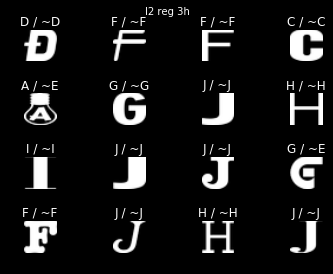

test accuracy 0.953642
Incorrect no: 868


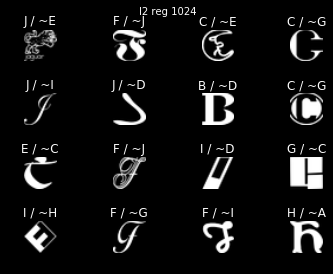

In [27]:
restore_and_display_test(graph, "l2 reg 3h")
restore_and_display_random_incorrect(16, graph, "l2 reg 1024")

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [7]:
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_batch_size = tf.placeholder(tf.int32)
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))    
    tf_keep_prob = tf.placeholder(tf.float32)
    
    regu_weights = []

    def convolution_block(block_name, input_data, prev_depth, conv_depth, patch_size, conv_stride,
                          pool_ksize=None, pool_stride=None, padding='SAME', hasLrn=True):
        with tf.variable_scope(block_name):
            weights = weight_variable([patch_size, patch_size, prev_depth, conv_depth], 20000, #patch_size*patch_size 20000 gives 0.01 stdev
                                     name=block_name + '_weights')
            biases = bias_variable([conv_depth], name=block_name + '_biases')
            conv = tf.nn.conv2d(input_data, weights, strides=conv_stride, padding=padding)
            hidden = tf.nn.elu(conv + biases)
            #lrn
            if hasLrn:
                lrn = tf.nn.local_response_normalization(hidden, depth_radius=5, alpha=0.0001, beta=0.75)
            else:
                lrn = hidden
            #pooling
            if pool_ksize is None:
                return lrn
            else:
                pool = tf.nn.max_pool(lrn, ksize=pool_ksize, strides=pool_stride, padding='SAME')
                return pool
            
    def fc_block(block_name, input_data, input_nodes, hidden_nodes):
        with tf.variable_scope(block_name):
            weights = weight_variable([input_nodes, hidden_nodes], input_nodes, name=block_name + '_weights')
            regu_weights.append(tf.nn.l2_loss(weights))
            biases = bias_variable([hidden_nodes], name=block_name + '_biases')
            hidden = tf.nn.elu(tf.matmul(input_data, weights) + biases)
            return tf.nn.dropout(hidden, tf_keep_prob)
            
    def model():        
        #data = convolution_block('conv3', data, 48, 64, 3, [1,1,1,1], padding='SAME', pool_ksize=None, hasLrn=False)
        #shape = data.get_shape().as_list()
        #print shape
        #data = convolution_block('conv4', data, 64, 64, 3, [1,1,1,1], padding='SAME', pool_ksize=None, hasLrn=False)
        #shape = data.get_shape().as_list()
        #print shape
        #data = convolution_block('conv5', data, 64, 48, 3, [1,1,1,1], [1,3,3,1], [1,1,1,1], 'SAME', hasLrn=False)        
        #print shape        
        data = convolution_block('conv1', tf_train_dataset, 1, 32, 5, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=True)
        shape = data.get_shape().as_list()
        print shape
        data = convolution_block('conv2', data, 32, 64, 5, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=True)        
        shape = data.get_shape().as_list()
        print shape
        data = convolution_block('conv3', data, 64, 128, 3, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=True)        
        shape = data.get_shape().as_list()
        print shape
        data = convolution_block('conv4', data, 128, 256, 3, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=True)        
        shape = data.get_shape().as_list()
        print shape
        data_flat = tf.reshape(data, [-1, shape[1] * shape[2] * shape[3]])
        input_nodes = 2 * 2 * 256#(image_size / 2) / 2 / 1
        data = fc_block('fc6', data_flat, input_nodes, 1024)
        shape = data.get_shape().as_list()
        print shape 
        data = fc_block('fc7', data, 1024, 256)
        shape = data.get_shape().as_list()
        print shape 
        data = fc_block('fc8', data, 256, 50)
        shape = data.get_shape().as_list()
        print shape 
        return data, 50
    
    def model_prob1():
        shape = tf_train_dataset.get_shape().as_list()
        print shape        
        data = convolution_block('conv1', tf_train_dataset, 1, 32, 5, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=False)
        shape = data.get_shape().as_list()
        print shape
        data = convolution_block('conv2', data, 32, 64, 5, [1,1,1,1], [1,2,2,1], [1,2,2,1], 'SAME', hasLrn=False)        
        shape = data.get_shape().as_list()
        print shape        
        data_flat = tf.reshape(data, [-1, shape[1] * shape[2] * shape[3]])
        input_nodes = 7 * 7 * 64#(image_size / 2) / 2 / 1
        data = fc_block('fc6', data_flat, input_nodes, 1024)
        shape = data.get_shape().as_list()
        print shape 
        data = fc_block('fc7', data, 1024, 256)
        shape = data.get_shape().as_list()
        print shape 
        data = fc_block('fc8', data, 256, 50)
        shape = data.get_shape().as_list()
        print shape 
        return data, 50
            
    # output layer variables
    data, exit_nodes = model()
    weights_o = weight_variable([exit_nodes, num_labels], exit_nodes)
    biases_o = bias_variable([num_labels])            
    #output operation
    logits_o = tf.matmul(data, weights_o) + biases_o
    y_conv = tf.nn.softmax(logits_o) #after softmax -> output probabilities / predictions
    #define loss
    print "L2 regu elems: %i" % len(regu_weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_o, tf_train_labels) +
                        (0 if len(regu_weights) == 0 else (2.0/(3*1024)) * sum(regu_weights)))
                            #* reduce(lambda q, p: p+q, x)))
                    #+ (2.0/(3*hidden_nodes))*(tf.nn.l2_loss(weights_i)
                    #+ tf.nn.l2_loss(weights_h2)
                    #+ tf.nn.l2_loss(weights_h3)))
    #decay learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step * tf_batch_size, train_dataset.shape[0] / 1, 0.95, staircase=True)
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #learning_rate = tf.constant(0.01)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    #define operations to measure accuracy
    is_correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
    accuracy_l = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))        
    #saving mode
    saver = tf.train.Saver(max_to_keep=20)   

[None, 14, 14, 32]
[None, 7, 7, 64]
[None, 4, 4, 128]
[None, 2, 2, 256]
[None, 1024]
[None, 256]
[None, 50]
L2 regu elems: 3


In [ ]:
train_model(50001, 500, 128, graph, is_saving=True, keep_prob = 0.7, restore=True)

session restored from ./model.ckpt-18000
Minibatch loss at step 0: 0.267122 with learning rate 0.069834
step 0, training accuracy 0.976562
Validation accuracy: 0.93057
Minibatch loss at step 500: 0.339107 with learning rate 0.069834
step 500, training accuracy 0.96875

test accuracy 0.967956 ./model.ckpt-13000
test accuracy 0.969398 ./model.ckpt-13500
test accuracy 0.970038 ./model.ckpt-14000
test accuracy 0.969237 ./model.ckpt-14500
test accuracy 0.971694 ./model.ckpt-15000
test accuracy 0.97116 ./model.ckpt-15500
test accuracy 0.970946 ./model.ckpt-16000
test accuracy 0.970519 ./model.ckpt-16500
test accuracy 0.970786 ./model.ckpt-17000
test accuracy 0.972121 ./model.ckpt-17500
test accuracy 0.971053 ./model.ckpt-18000
test accuracy 0.970893 ./model.ckpt-18500
test accuracy 0.972495 ./model.ckpt-19000
test accuracy 0.972869 ./model.ckpt-19500
test accuracy 0.972816 ./model.ckpt-20000
test accuracy 0.972228 ./model.ckpt-20500
test accuracy 0.972015 ./model.ckpt-21000
test accuracy 0.972442 ./model.ckpt-21500
test accuracy 0.972655 ./model.ckpt-22000
test accuracy 0.973457 ./model.ckpt-22500
test accuracy 0.973457
Incorrect no: 497


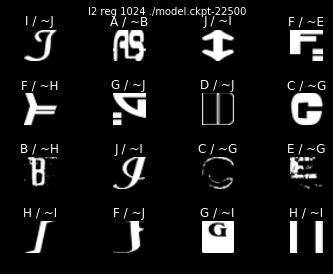

In [120]:
restore_and_display_test(graph, "l2 reg 3h", display_all=True)
restore_and_display_random_incorrect(16, graph, "l2 reg 1024")

A good result no 1:

    test accuracy 0.973457
    Incorrect no: 497
    
for elu activation, l2 regu, maximum at 19000 step

    [None, 28, 28, 1]
    [None, 14, 14, 32]
    [None, 7, 7, 64]
    [None, 1024]
    [None, 256]
    [None, 50]
    L2 regu elems: 3
    train_model(50001, 500, 128, graph, is_saving=True, keep_prob = 0.8)
    
    step 19000, training accuracy 0.953125
    Validation accuracy: 0.931158
    Minibatch loss at step 19500: 0.336240 with learning rate 0.066342
    step 19500, training accuracy 0.960938
    Validation accuracy: 0.929022
    Minibatch loss at step 20000: 0.383364 with learning rate 0.066342
    step 20000, training accuracy 0.953125
    Validation accuracy: 0.929022
    Minibatch loss at step 20500: 0.252442 with learning rate 0.066342
    step 20500, training accuracy 0.992188
    Validation accuracy: 0.929342
    Minibatch loss at step 21000: 0.328111 with learning rate 0.066342
    step 21000, training accuracy 0.96875
    Validation accuracy: 0.929128
    Minibatch loss at step 21500: 0.289328 with learning rate 0.063025
    step 21500, training accuracy 0.992188
    Validation accuracy: 0.928701
    Minibatch loss at step 22000: 0.368480 with learning rate 0.063025
    step 22000, training accuracy 0.960938
    Validation accuracy: 0.927366
    Minibatch loss at step 22500: 0.335005 with learning rate 0.063025
    step 22500, training accuracy 0.976562
    Validation accuracy: 0.93057
    
    test accuracy 0.967956 ./model.ckpt-13000
    test accuracy 0.969398 ./model.ckpt-13500
    test accuracy 0.970038 ./model.ckpt-14000
    test accuracy 0.969237 ./model.ckpt-14500
    test accuracy 0.971694 ./model.ckpt-15000
    test accuracy 0.97116 ./model.ckpt-15500
    test accuracy 0.970946 ./model.ckpt-16000
    test accuracy 0.970519 ./model.ckpt-16500
    test accuracy 0.970786 ./model.ckpt-17000
    test accuracy 0.972121 ./model.ckpt-17500
    test accuracy 0.971053 ./model.ckpt-18000
    test accuracy 0.970893 ./model.ckpt-18500
    test accuracy 0.972495 ./model.ckpt-19000
    test accuracy 0.972869 ./model.ckpt-19500
    test accuracy 0.972816 ./model.ckpt-20000
    test accuracy 0.972228 ./model.ckpt-20500
    test accuracy 0.972015 ./model.ckpt-21000
    test accuracy 0.972442 ./model.ckpt-21500
    test accuracy 0.972655 ./model.ckpt-22000
    test accuracy 0.973457 ./model.ckpt-22500
    